In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy.fft as nf
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [2]:
def filter_data(df):
    b, a = signal.butter(3, 0.15, btype='lowpass', analog=False)
    low_passed = signal.filtfilt(b, a, df['aT (m/s^2)'])
    #peaks,_ = signal.find_peaks(df['aT (m/s^2)'])
    #plt.plot(df['time'],low_passed)
    #plt.plot(df['time'],df['aT (m/s^2)'])
    return low_passed


def calculate_vel(df):
    temp=df.shift(periods=-1)
    diff_df=abs(df-temp)
    temp_df=diff_df.shift(periods=1)
    temp_df.iloc[0]=df.iloc[0]
    df['diff_time']=temp_df['time']
    df['velocity']=df['diff_time']*df['aT (m/s^2)']
    return df
    

def calculate_delta_position(df):
    df['position']=df['diff_time']*df['velocity']
    return df

def calculate_total_position(df):
    df2=df
    df2=df2.cumsum(axis=0)
    df['total_position']=df2['position']
    return df


def transform_df(df):
    #using the above function to form the final df we want
    df['aT (m/s^2)']=filter_data(df)
    df=calculate_vel(df)
    df=calculate_delta_position(df)
    df=calculate_total_position(df)
    df = df[0:16000]

    return df


def get_model(df):
    X=np.stack([df['time']],axis=1)
    X_with=np.concatenate([np.ones(X.shape),X],axis=1)
    model=LinearRegression(fit_intercept=False)
    model.fit(X_with,df['total_position'])
    return model
    

def get_model_train_set(df):
    X=np.stack([df['time']],axis=1)
    X_with=np.concatenate([np.ones(X.shape),X],axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_with,df['total_position'])
    return X_train, X_valid, y_train, y_valid



In [3]:
#foot model:10 mins
df=pd.read_csv('foot') 
df=transform_df(df)
model_long=get_model(df)

#print(model.coef_)

# foot model:3 mins
right=pd.read_csv('right_foot')
right=transform_df(right)
model_short=get_model(right)



In [4]:
# CHECK if length of data set will change the score (use 10min as the model)


#enter the right foot (long)
right_test=pd.read_csv('foot')
right_test=transform_df(right_test)
X=np.stack([right_test['time']],axis=1)
X_with=np.concatenate([np.ones(X.shape),X],axis=1)
print("The right foot score (long version) in (long version) is " , model_long.score(X_with,right_test['total_position']))


print("The right foot score (long version) in (short version) is " , model_short.score(X_with,right_test['total_position']))




#enter the right foot (short)
right_test1=pd.read_csv('right_foot_1')
right_test1=transform_df(right_test1)
X=np.stack([right_test1['time']],axis=1)
X_with=np.concatenate([np.ones(X.shape),X],axis=1)
print("The right foot score (short version) in (long version) is " , model_long.score(X_with,right_test1['total_position']))


print("The right foot score (short version) in (short version) is " , model_short.score(X_with,right_test1['total_position']))



#enter the injury csv (long)
injury=pd.read_csv('long_injury')
injury=transform_df(injury)
X2=np.stack([injury['time']],axis=1)
X2_with=np.concatenate([np.ones(X2.shape),X2],axis=1)
print("The injury foot score (long version) in (long version) is ",model_long.score(X2_with,injury['total_position']))

print("The injury foot score (long version) in (short version) is ",model_short.score(X2_with,injury['total_position']))




#enter the injury csv (short)

injury1=pd.read_csv('injury')
injury1=transform_df(injury1)
X2=np.stack([injury1['time']],axis=1)
X2_with=np.concatenate([np.ones(X2.shape),X2],axis=1)
print("The injury foot score (short version) in (long version) is ",model_long.score(X2_with,injury1['total_position']))

print("The injury foot score (short version) in (short version) is ",model_short.score(X2_with,injury1['total_position']))



The right foot score (long version) in (long version) is  0.9541969864910708
The right foot score (long version) in (short version) is  -0.5678366326635695
The right foot score (short version) in (long version) is  -0.25827248059251473
The right foot score (short version) in (short version) is  0.4552221778850343
The injury foot score (long version) in (long version) is  -9.450070095947572
The injury foot score (long version) in (short version) is  -38.00709471417785
The injury foot score (short version) in (long version) is  0.3175096683182349
The injury foot score (short version) in (short version) is  -4.473916943684097


In [5]:
list_of_title = np.array(['right_foot_1','right_foot_2','right_foot_3','female_1','female_2',
                                    'injury','injury_1','injury_2'])
list_of_situation = np.array(['0','0','0','0','0','1','1','1',])

list_of_whole = []
for i in range(8):
    input_file = pd.read_csv(list_of_title[i])
    input_file = transform_df(input_file)
    
    X_train, X_valid, y_train, y_valid = get_model_train_set(input_file)
    
    print("The normal situation of input",list_of_title[i], "is ", list_of_situation[i])
    temp1 = model_short.score(X_train,y_train)
    temp2 = model_short.score(X_valid,y_valid)
    print("The train socre of input",list_of_title[i], "is ", temp1)
    print("The valid socre of input",list_of_title[i], "is ", temp2)
    list_of_whole.append([])
    list_of_whole[i].append(temp1)
    list_of_whole[i].append(temp2)
    list_of_whole[i].append(list_of_situation[i])
    


The normal situation of input right_foot_1 is  0
The train socre of input right_foot_1 is  0.45567017653995434
The valid socre of input right_foot_1 is  0.4538761475642292
The normal situation of input right_foot_2 is  0
The train socre of input right_foot_2 is  0.391402191623906
The valid socre of input right_foot_2 is  0.385542265910214
The normal situation of input right_foot_3 is  0
The train socre of input right_foot_3 is  0.9343007227614943
The valid socre of input right_foot_3 is  0.9330786112624907
The normal situation of input female_1 is  0
The train socre of input female_1 is  0.9213090929751391
The valid socre of input female_1 is  0.9226137396684118
The normal situation of input female_2 is  0
The train socre of input female_2 is  0.8038157873979389
The valid socre of input female_2 is  0.8064990701046963
The normal situation of input injury is  1
The train socre of input injury is  -4.468168315320719
The valid socre of input injury is  -4.49130750452551
The normal situati

In [6]:
list_of_whole

[[0.45567017653995434, 0.4538761475642292, '0'],
 [0.391402191623906, 0.385542265910214, '0'],
 [0.9343007227614943, 0.9330786112624907, '0'],
 [0.9213090929751391, 0.9226137396684118, '0'],
 [0.8038157873979389, 0.8064990701046963, '0'],
 [-4.468168315320719, -4.49130750452551, '1'],
 [-13.023028198464699, -13.665777531438561, '1'],
 [-12.503651618712839, -12.612606024823833, '1']]

In [7]:
dataframe = pd.DataFrame(list_of_whole,columns = ['train_score','valid_score','situation'],index = ['right_foot_1','right_foot_2','right_foot_3',
                                                        'female_1','female_2','injury','injury_1','injury_2'])

dataframe

,train_score,valid_score,situation
right_foot_1,0.455670,0.453876,0
right_foot_2,0.391402,0.385542,0
right_foot_3,0.934301,0.933079,0
female_1,0.921309,0.922614,0
female_2,0.803816,0.806499,0
injury,-4.468168,-4.491308,1
injury_1,-13.023028,-13.665778,1
injury_2,-12.503652,-12.612606,1


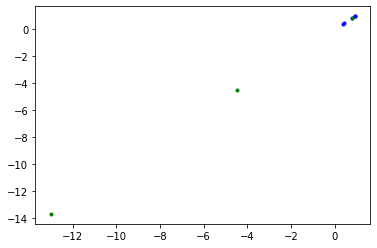

In [8]:
zero=dataframe.iloc[0:5,:]
one=dataframe.iloc[4:7,:]
plt.plot(zero['train_score'],zero['valid_score'],'b.')
plt.plot(one['train_score'],one['valid_score'],'g.')
#plt.plot(dataframe['train_score'].iloc[])

In [9]:
#plug the dataframe into classifier
G_model=GaussianNB()
X=dataframe[['train_score','valid_score']]
y=dataframe['situation']
G_model.fit(X,y)
print(G_model.theta_)
print(G_model.sigma_)

[[  0.70129959   0.70032197]
 [ -9.99828271 -10.25656369]]
[[ 0.05391473  0.05493697]
 [15.33604132 16.80395116]]


In [15]:
#test the model working state， and worked
#if it fits injury_classifier and also matches the answer of normal_classifier, then true
test=pd.read_csv('male_5')
test=transform_df(test)
X_train, X_valid, y_train, y_valid = get_model_train_set(test)
temp1 = model_short.score(X_train,y_train)
temp2 = model_short.score(X_valid,y_valid)
X_check=[[temp1,temp2]]
G_model.predict(X_check)

array(['0'], dtype='<U1')